In [1]:
#  t! pip install ftfy regex tqdm

In [2]:
# ! pip install git+https://github.com/openai/CLIP.git

In [1]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter
# import skimage

import clip #importing clip model

print("Torch version:", torch.__version__)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.0.0+cu117


In [2]:
device = "cpu"
if torch.cuda.is_available:
  print('cuda available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

cuda available


In [3]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
# 왜 vit32 사용했는지

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [5]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [6]:
print(input_resolution)
print(context_length)
print(vocab_size)

224
77
49408


In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f2a5ce78310>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [8]:
# 토크나이저 예시
clip.tokenize("smile")

tensor([[49406,  3490, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Zero shot downstream task

## Visualizing`

In [9]:
from torchvision.datasets import CIFAR100, MNIST

mnist = MNIST(os.path.expanduser("~/.cache"), transform=preprocess, download=False) #exploiting CLIP preprocess for dataset transformation

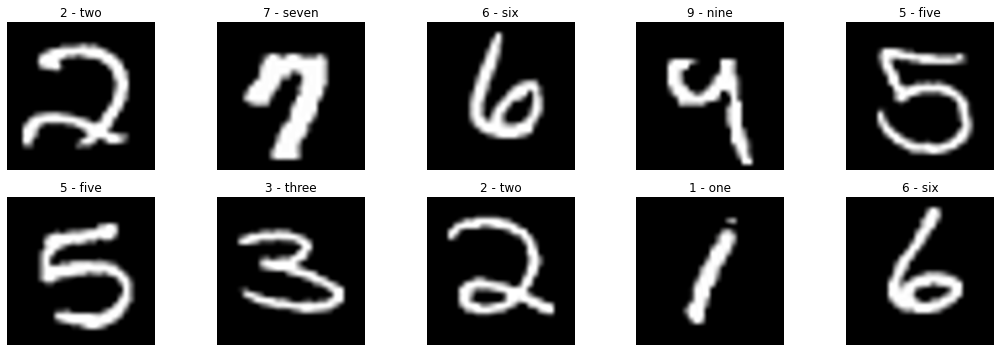

In [10]:
mean_mnist = [0.48145466, 0.4578275, 0.40821073]
std_mnist = [0.26862954, 0.26130258, 0.27577711]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean_mnist, std_mnist)
show_grid(mnist, process=denormalize)

## Batch 처리 : {label}

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import clip

from torchvision.datasets import MNIST

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

# 데이터셋 불러오기
mnist = MNIST(os.path.expanduser("~/.cache"), transform=preprocess, download=False)

# 데이터셋을 훈련 세트와 검증 세트로 분할
val_set, test_set = torch.utils.data.random_split(mnist, [0, 60000])

# 데이터 로더 정의
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 모델 및 텍스트 토큰화 함수 정의
text_tokens = clip.tokenize(mnist.classes).to(device)

# 모델 추론 및 정확도 계산
correct_labels = 0
total_labels = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 이미지 특성 추출
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # 텍스트 특성 추출
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 텍스트 특성과의 유사도 계산
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(5, dim=-1)

        # 정확도 계산
        correct_labels += (top_labels[:, 0] == labels).sum().item()
        total_labels += labels.size(0)

# 정확도 출력
accuracy = correct_labels / total_labels
print("The overall accuracy for the CLIP Zero-shot model without ensembling is: {}".format(accuracy))
print("Number of correct labels:", correct_labels)


The overall accuracy for the CLIP Zero-shot model without ensembling is: 0.3637
Number of correct labels: 21822


## Batch 처리 : a photo of a {label}

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import clip

from torchvision.datasets import MNIST

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

# 데이터셋 불러오기
mnist = MNIST(os.path.expanduser("~/.cache"), transform=preprocess, download=False)

# 데이터셋을 훈련 세트와 검증 세트로 분할
val_set, test_set = torch.utils.data.random_split(mnist, [0, 60000])

# 데이터 로더 정의
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 모델 및 텍스트 토큰화 함수 정의
text_descriptions = [f"a photo of a {label}" for label in mnist.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

# 모델 추론 및 정확도 계산
correct_labels = 0
total_labels = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 이미지 특성 추출
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # 텍스트 특성 추출
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 텍스트 특성과의 유사도 계산
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(5, dim=-1)

        # 정확도 계산
        correct_labels += (top_labels[:, 0] == labels).sum().item()
        total_labels += labels.size(0)

# 정확도 출력
accuracy = correct_labels / total_labels
print("The overall accuracy for the CLIP Zero-shot model with ensembling is: {}".format(accuracy))
print("Number of correct labels:", correct_labels)


The overall accuracy for the CLIP Zero-shot model with ensembling is: 0.32753333333333334
Number of correct labels: 19652


## Batch 처리 : gpt prompt

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import clip

from torchvision.datasets import MNIST

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

# 데이터셋 불러오기
mnist = MNIST(os.path.expanduser("~/.cache"), transform=preprocess, download=False)

# 데이터셋을 훈련 세트와 검증 세트로 분할
val_set, test_set = torch.utils.data.random_split(mnist, [0, 60000])

# 데이터 로더 정의
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 모델 및 텍스트 토큰화 함수 정의
text_descriptions = ["This is an image of the digit zero. It is a handwritten digit with a circular shape.",
                     "This is an image of the digit one. It is a handwritten digit with a single vertical stroke.",
    "This is an image of the digit two. It is a handwritten digit with two horizontal strokes.",
    "This is an image of the digit three. It is a handwritten digit with a curved top and a vertical stroke.",
    "This is an image of the digit four. It is a handwritten digit with a vertical stroke and a horizontal stroke.",
    "This is an image of the digit five. It is a handwritten digit with a curved top and a diagonal stroke.",
    "This is an image of the digit six. It is a handwritten digit with a curved top and a loop at the bottom.",
    "This is an image of the digit seven. It is a handwritten digit with a horizontal stroke and a diagonal stroke.",
    "This is an image of the digit eight. It is a handwritten digit with two curved strokes, one on top and one on the bottom.",
    "This is an image of the digit nine. It is a handwritten digit with a curved stroke on the left and a diagonal stroke on the right."]
text_tokens = clip.tokenize(text_descriptions).to(device)

# 모델 추론 및 정확도 계산
correct_labels = 0
total_labels = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 이미지 특성 추출
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # 텍스트 특성 추출
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 텍스트 특성과의 유사도 계산
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(5, dim=-1)

        # 정확도 계산
        correct_labels += (top_labels[:, 0] == labels).sum().item()
        total_labels += labels.size(0)

# 정확도 출력
accuracy = correct_labels / total_labels
print("The overall accuracy for the CLIP Zero-shot model with gpt prompt engineering is: {}".format(accuracy))
print("Number of correct labels:", correct_labels)


The overall accuracy for the CLIP Zero-shot model with gpt prompt engineering is: 0.24403333333333332
Number of correct labels: 14642


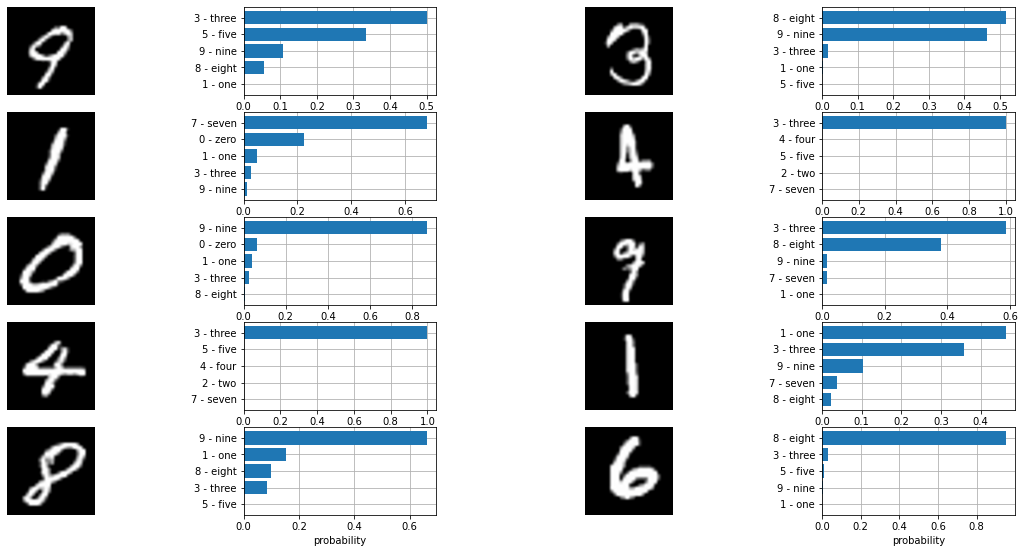

In [52]:
# plt.figure(figsize=(19, 19))
# #taking random index for random sampling
# random_index = np.random.randint(10, size=10, high=len(image_input))
# image_input_sample = [(image_input[x],x) for x in random_index] 
# for i, image in enumerate(image_input_sample):
#     plt.subplot(len(image_input_sample), 4, 2 * i + 1)
#     #denormalizing the image and transforming to PIL image
#     image_processed = denormalize(image[0].cpu())
#     plt.imshow(transforms.ToPILImage()(image_processed))

#     plt.axis("off")

#     plt.subplot(len(image_input_sample), 4, 2 * i + 2)
#     y = np.arange(top_probs.shape[-1])
#     plt.grid()
#     plt.barh(y, top_probs[image[1]])
#     plt.gca().invert_yaxis()
#     plt.gca().set_axisbelow(True)
#     plt.yticks(y, [mnist.classes[index] for index in top_labels[image[1]].numpy()])
#     plt.xlabel("probability")

# plt.subplots_adjust(wspace=0.5)
# plt.show()